# Solving Maxwell's equations with convolutional neural networks

In [1]:
import h5py

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
# from tensorboardX import SummaryWriter

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from angler import Simulation
from time import time

# from datasets.generators import *
from datasets.generators1d import * 
from models.utils import pbar

# import keras
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LSTM, ConvLSTM2D, Reshape, Permute

## 1D Simulations

In [53]:
make_batch(perm_random_layers, "random_layers", N=10000)

In [174]:
data_batch = load_batch("datasets/test_1d.hdf5", "alternating_layers")

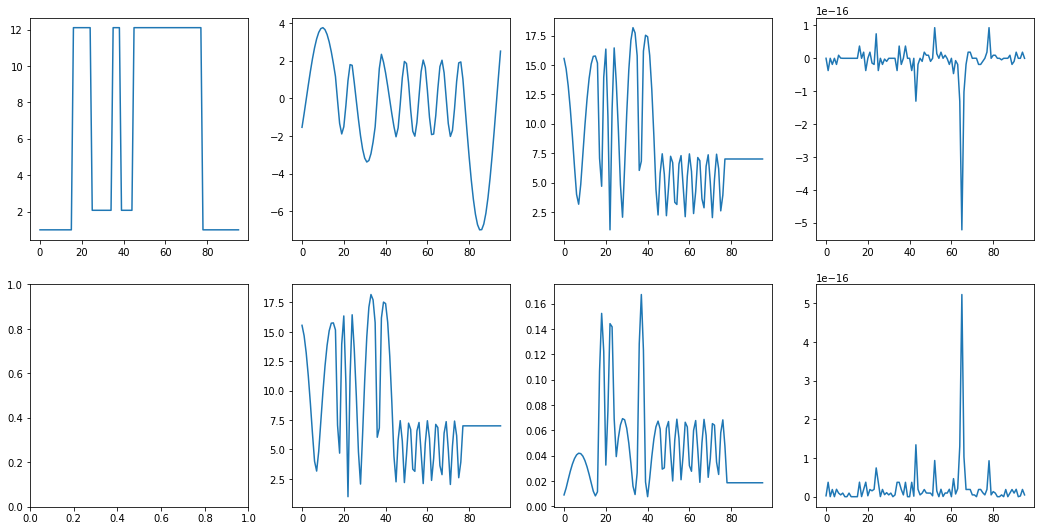

In [178]:
n = np.random.randint(0,500)
f, axarr = plt.subplots(2, 4, figsize=(18,9))

epsilons = data_batch["epsilons"][n]
Hx = data_batch["Hx"][n]
Hy = data_batch["Hy"][n]
Ez = data_batch["Ez"][n]
        
axarr[0,0].plot(epsilons)
axarr[0,1].plot(np.real(Ez))
axarr[0,2].plot(np.abs(Ez))
axarr[0,3].plot(np.real(Hy))
axarr[1,1].plot(np.abs(Ez))
axarr[1,2].plot(np.abs(Hx))
axarr[1,3].plot(np.abs(Hy))
plt.show()

In [183]:
diffs = np.diff(np.real(Ez), n=2)
ez = np.real(Ez)[1:-1]
eps = epsilons[1:-1]

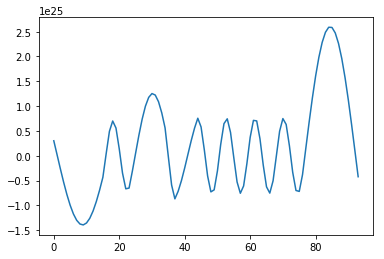

In [189]:
omega = 1.215e15
mu0 = 4 * np.pi * 10**-7
e0 = 8.854e-12 
l0 = 0.05 * 1e-6

plt.plot(1/(e0*eps) * diffs / l0 / l0 - ez * omega**2 * mu0 )
# plt.plot()
plt.show()

### 1D convolutional model definitions

In [5]:
class Perm1dDataset(Dataset):
    """Dataset for 1D permittivity/field data"""

    def __init__(self, hdf5_file, batch_name, kernel_sizes):
        
        data = load_batch(hdf5_file, batch_name)
        
        self.epsilons = data["epsilons"] 
        self.Hx = data["Hx"] 
        self.Hy = data["Hy"]
        self.Ez = data["Ez"]
                
        self.input_size = self.Ez[0].shape[0]
        output_size = self.input_size
        for kernel_size in kernel_sizes:
            stride = 1
            output_size = (output_size - kernel_size) / stride + 1
        self.output_size = int(output_size)
        
    def __len__(self):
        return len(self.epsilons)

    def __getitem__(self, i):
        data = torch.tensor([self.epsilons[i]]).float()
        
#         start = (self.input_size - self.output_size) // 2
#         end = start + self.output_size
#         label = torch.tensor(np.abs(self.Ez[i][start:end, start:end] * self.field_scale)).float()

        label = torch.tensor([np.abs(self.Ez[i][-1])]).float()
        
        return data, label
    
    
class Conv1dNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_channels = 1
        self.output_channels = 1
        
        self.conv_channels = [16, 16, 24, 32, 24]
        self.kernel_sizes = [25, 11, 7, 5, 3]
        
        self.input_size = 96
        output_size = self.input_size
        for kernel_size in self.kernel_sizes:
            stride = 1
            output_size = (output_size - kernel_size) / stride + 1
        self.output_size = int(output_size)

        layers = []
        
        in_channels = self.input_channels # number of input channels
        for out_channels, kernel_size in zip(self.conv_channels, self.kernel_sizes):
            layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=0))
            in_channels = out_channels
        
        self.convolutions = nn.ModuleList(layers)
        self.conv_output_size = self.output_size * self.conv_channels[-1]
    
        self.hidden_size = 256
        self.dense1 = nn.Linear(self.conv_output_size, self.hidden_size)
        self.dense2 = nn.Linear(self.hidden_size, 1)
        
    def forward(self, x):
        out = x
        for i, layer in enumerate(self.convolutions):
            out = layer(out)
            out = nn.ReLU()(out)
            
        # Flatten
        out = torch.reshape(out, (-1, self.conv_output_size))
        
        # Dense layer
        out = self.dense1(out)
        out = nn.ReLU()(out)
        out = self.dense2(out)
        
        return out
    

In [7]:
# Device configuration
device = torch.device('cpu')

# Create a model   
model = Conv1dNet().to(device)
# writer = SummaryWriter()

# Create data loaders
batch_size = 250

permittivity_data = Perm1dDataset("datasets/test_1d.hdf5", "alternating_layers", model.kernel_sizes)
train_size = int(0.9 * len(permittivity_data))
test_size = len(permittivity_data) - train_size
train_data, test_data = random_split(permittivity_data, [train_size, test_size])
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [ ]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.001

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.1)
losses = []

# Train the model
total_step = len(train_loader)
iterator = pbar(range(num_epochs))
for epoch in iterator:
    
#     iterator = pbar(train_loader)
    for data, labels in train_loader: #iterator:
        data = data.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        iterator.set_description("ℒ = {:.2f}".format(loss.item()), refresh=False)

# Save the model checkpoint
torch.save(model.state_dict(), 'model1d.ckpt')
lossesN = np.array(losses)
np.save("losses.npy", lossesN)

In [8]:
model.load_state_dict(torch.load('model1d_nov15.ckpt'))

In [9]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
data_list = []
labels_list = []
outputs_list = []

with torch.no_grad():
    for data, labels in pbar(test_loader):
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        data_list.append(data)
        labels_list.append(labels)
        outputs_list.append(outputs)
        
t_true = [tensor.item() for tensor in labels_list]
t_pred = [tensor.item() for tensor in outputs_list]

#### Speed comparison:
- Model feed foward on CPU: ~518 iterations / second
- FDFD solve speed on CPU: ~102 iterations / second

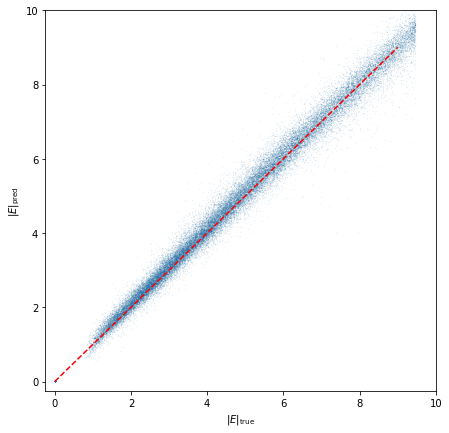

In [44]:
plt.figure(figsize=(7,7))
plt.scatter(t_true, t_pred, s=0.001)
plt.plot(np.arange(10), np.arange(10), c="red", linestyle="dashed")
plt.xlabel("$|E|_\mathrm{true}$")
plt.ylabel("$|E|_\mathrm{pred}$")
plt.xlim(-.25,10)
plt.ylim(-.25,10)
plt.show()

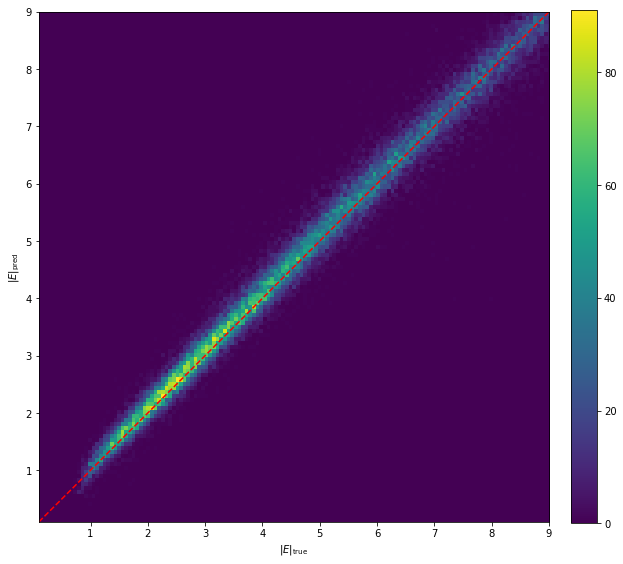

In [42]:
heatmap, xedges, yedges = np.histogram2d(t_true, t_pred, bins=150)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10,10))
im = plt.imshow(heatmap[1:,1:].T, extent=extent, origin='lower')
plt.plot(np.arange(10), np.arange(10), c="red", linestyle="dashed")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xlabel("$|E|_\mathrm{true}$")
plt.ylabel("$|E|_\mathrm{pred}$")
plt.xlim(0.1,9)
plt.ylim(0.1,9)
plt.show()

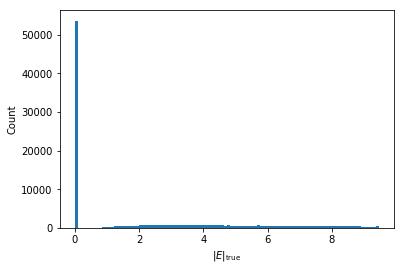

In [45]:
n, bins, patches = plt.hist(t_true, 100)
plt.xlabel('$|E|_\mathrm{true}$')
plt.ylabel('Count')
plt.show()

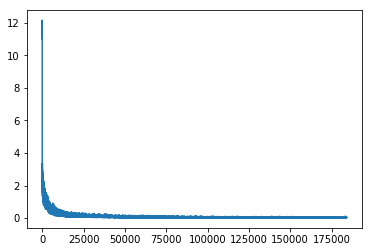

In [10]:
losses_npy = np.load("losses.npy")
plt.plot(losses)
plt.show()

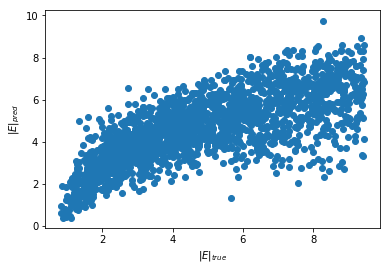

In [59]:
plt.scatter(t_true, t_pred)
plt.xlabel("$|E|_{true}$")
plt.ylabel("$|E|_{pred}$")
plt.show()

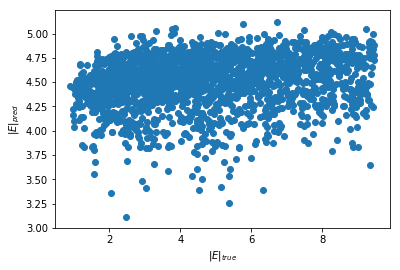

In [48]:
plt.scatter(t_true, t_pred)
plt.xlabel("$|E|_{true}$")
plt.ylabel("$|E|_{pred}$")
plt.show()

## First-layer kernel weights analysis

In [107]:
conv1 = list(list(model.modules())[1])[0]
weights = list(conv1.parameters())[0].data.numpy()
weights = weights[:,0,:]

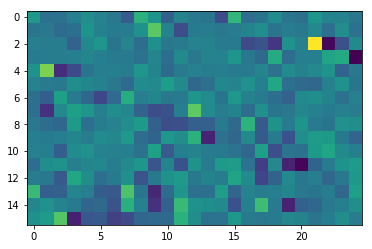

In [108]:
plt.imshow(weights)
plt.show()

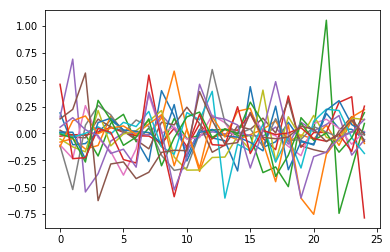

In [109]:
[plt.plot(weight) for weight in weights]
plt.show()

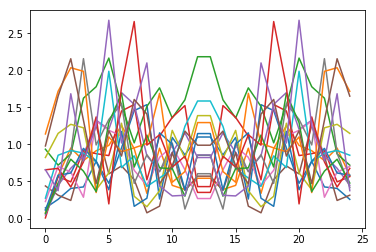

In [115]:
[plt.plot(np.abs(np.fft.fft(weight))) for weight in weights]
plt.show()

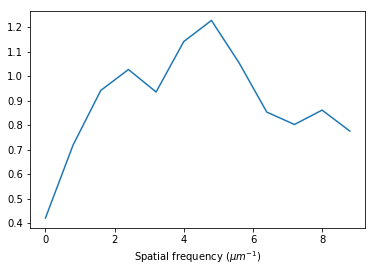

In [134]:
avg_abs_fft = np.mean([np.abs(np.fft.fft(weight)) for weight in weights], axis=0)[0:25//2] # x-spacing = 0.05 um
freqs = np.fft.fftfreq(25, 0.05)[0:25//2] # units of um^-1

N_si = 3.48
lambda_si = 1.55 / N_si
N_sio2 = 1.44
lambda_si02 = 1.55 / N_sio2

plt.plot(freqs, avg_abs_fft)
plt.xlabel("Spatial frequency ($\mu m ^{-1}$)")
plt.show()

^ See Mathematica calculations for possible explanation

## Testing on different distribution

In [57]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
labels_list = []
outputs_list = []

random_number_alternating_layer_data = Perm1dDataset("datasets/test_1d.hdf5", "random_number_alternating_layers", model.kernel_sizes)
test_random_number_alternating_layer_loader = DataLoader(dataset=random_number_alternating_layer_data, batch_size=1, shuffle=False)

with torch.no_grad():
    for data, labels in pbar(test_random_number_alternating_layer_loader):
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        labels_list.append(labels)
        outputs_list.append(outputs)
        
t_true_1 = [tensor.item() for tensor in labels_list]
t_pred_1 = [tensor.item() for tensor in outputs_list]

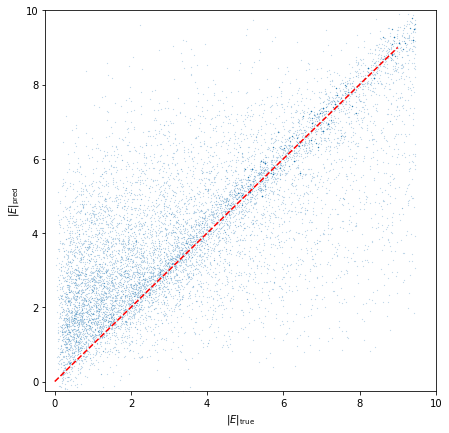

In [68]:
plt.figure(figsize=(7,7))
plt.scatter(t_true_1, t_pred_1, s=0.01)
plt.plot(np.arange(10), np.arange(10), c="red", linestyle="dashed")
plt.xlabel("$|E|_\mathrm{true}$")
plt.ylabel("$|E|_\mathrm{pred}$")
plt.xlim(-.25,10)
plt.ylim(-.25,10)
plt.show()

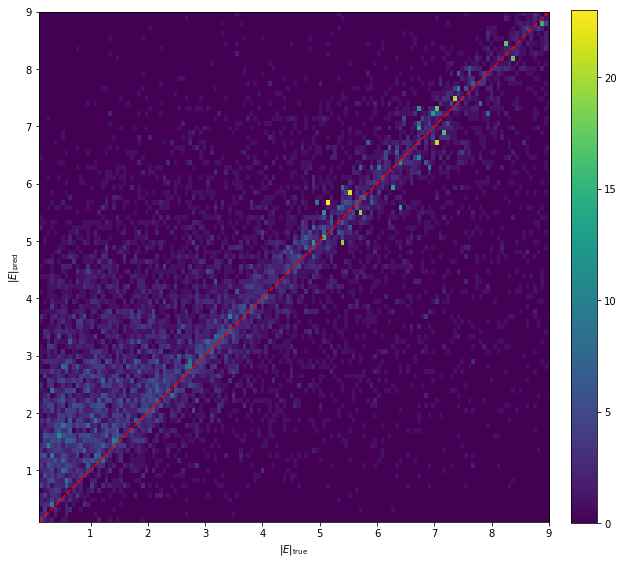

In [58]:
heatmap, xedges, yedges = np.histogram2d(t_true_1, t_pred_1, bins=150)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10,10))
im = plt.imshow(heatmap[1:,1:].T, extent=extent, origin='lower')
plt.plot(np.arange(10), np.arange(10), c="red", linestyle="dashed")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xlabel("$|E|_\mathrm{true}$")
plt.ylabel("$|E|_\mathrm{pred}$")
plt.xlim(0.1,9)
plt.ylim(0.1,9)
plt.show()

In [59]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
labels_list = []
outputs_list = []

random_layers_data = Perm1dDataset("datasets/test_1d.hdf5", "random_layers", model.kernel_sizes)
test_random_layer_loader = DataLoader(dataset=random_layers_data, batch_size=1, shuffle=False)

with torch.no_grad():
    for data, labels in pbar(test_random_layer_loader):
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        labels_list.append(labels)
        outputs_list.append(outputs)
        
t_true_2 = [tensor.item() for tensor in labels_list]
t_pred_2 = [tensor.item() for tensor in outputs_list]

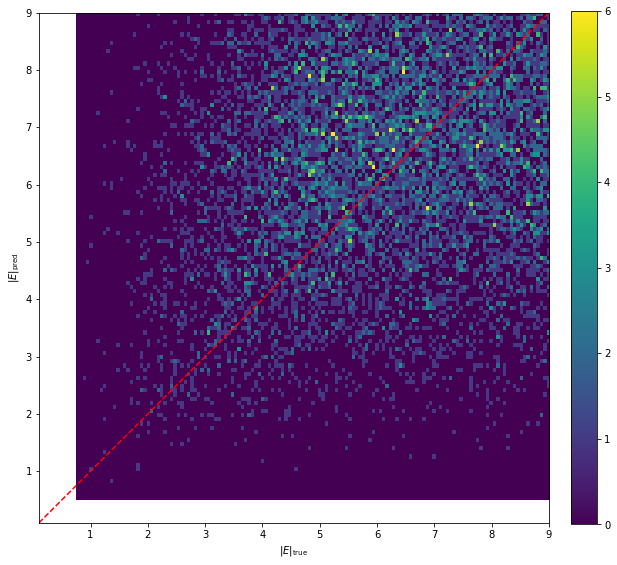

In [61]:
heatmap, xedges, yedges = np.histogram2d(t_true_2, t_pred_2, bins=150)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(10,10))
im = plt.imshow(heatmap[1:,1:].T, extent=extent, origin='lower')
plt.plot(np.arange(10), np.arange(10), c="red", linestyle="dashed")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xlabel("$|E|_\mathrm{true}$")
plt.ylabel("$|E|_\mathrm{pred}$")
plt.xlim(0.1,9)
plt.ylim(0.1,9)
plt.show()

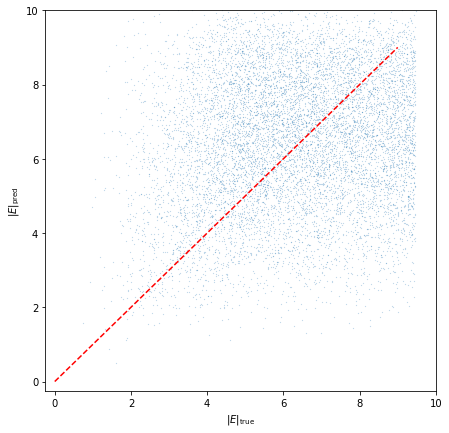

In [69]:
plt.figure(figsize=(7,7))
plt.scatter(t_true_2, t_pred_2, s=0.01)
plt.plot(np.arange(10), np.arange(10), c="red", linestyle="dashed")
plt.xlabel("$|E|_\mathrm{true}$")
plt.ylabel("$|E|_\mathrm{pred}$")
plt.xlim(-.25,10)
plt.ylim(-.25,10)
plt.show()

In [ ]:
n = np.random.randint(0,20000*0.1)

eps = data_list[n]
# Ez, Hx, Hy mode
eps, Ez_vac, Hx_vac, Hy_vac = data_list[n][m]
# Ez_true, Hx_true, Hy_true = labels_list[n][m]
# Ez_pred, Hx_pred, Hy_pred = outputs_list[n][m]

# Just Ez mode
# eps, Ez_vac = data_list[n][m]
Ez_true = labels_list[n][m][0]
Ez_pred = outputs_list[n][m][0]

f, axarr = plt.subplots(3,3, figsize=(12,12))

axarr[0,0].imshow(eps)
axarr[0,1].imshow(Ez_vac)
axarr[0,2].imshow(Hx_vac)

axarr[1,0].imshow(Ez_true)
# axarr[1,1].imshow(Hx_true)
# axarr[1,2].imshow(Hy_true)

axarr[2,0].imshow(Ez_pred)
# axarr[2,1].imshow(Hx_pred)
# axarr[2,2].imshow(Hy_pred)
plt.show()

## 2D Simulations

In [2]:
make_batch(perm_rectangle, "rectangles", N=2000, omega=1.215e15)

In [167]:
data_batch = load_batch("datasets/test.hdf5", "ellipses")

KeyError: 'Hx_vac'

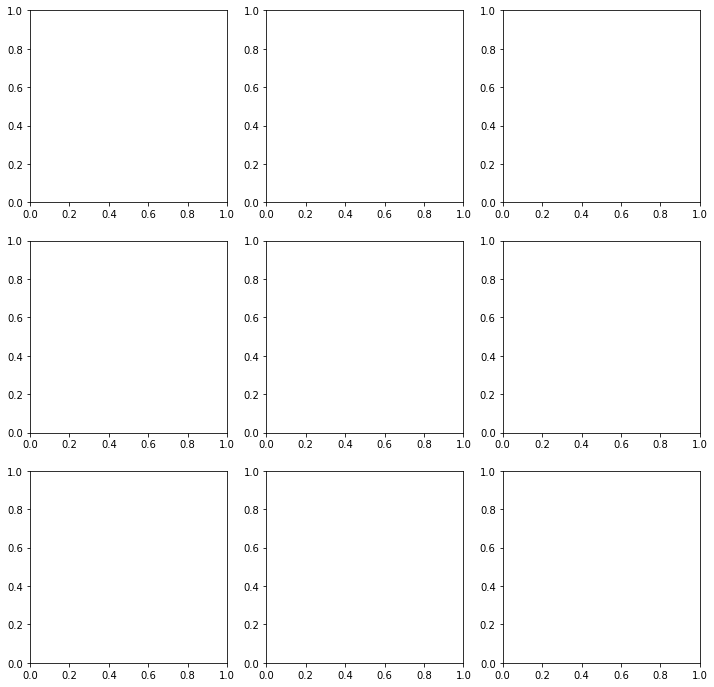

In [172]:
# Show a random data point in the batch
n = np.random.randint(0,500)
f, axarr = plt.subplots(3,3, figsize=(12,12))

epsilons = data_batch["epsilons"][n]
# proximities = data_batch["proximities"][n]
Hx = data_batch["Hx"][n]
Hy = data_batch["Hy"][n]
Ez = data_batch["Ez"][n]
Hx_vac = data_batch["Hx_vac"][n]
Hy_vac = data_batch["Hy_vac"][n]
Ez_vac = data_batch["Ez_vac"][n]
        
axarr[0,0].imshow(epsilons)
axarr[0,1].imshow(np.abs(Ez))
# axarr[0,2].imshow(np.real(Ez_vac))
axarr[1,0].imshow(np.real(Ez))
axarr[1,1].imshow(np.real(Hx))
axarr[1,2].imshow(np.real(Hy))
# axarr[2,0].imshow(np.real(Ez + 1j * Hx))
# axarr[2,1].imshow(np.real(Ez + 1j * Hy))
# axarr[2,2].imshow(np.abs(Ez + 1j * Hx + 1j * Hy))
plt.show()

## PyTorch model

In [157]:
# Device configuration
device = torch.device('cpu')

# Hyperparameters
num_epochs = 1
batch_size = 100
learning_rate = 0.001


class PermittivityDataset(Dataset):
    """Dataset for 2D permittivity/field training data"""

    def __init__(self, hdf5_file, batch_name, kernel_sizes):
        
        data = load_batch(hdf5_file, batch_name)
        
        # Scale down all fields by some factor to make them all in (-1, 1)
        # max_val = np.max(np.abs([self.Hx, self.Hy, self.Ez, self.Hx_vac, self.Hy_vac, self.Ez_vac]))
        self.field_scale = 1#1/4
        self.epsilon_scale = 1#/10
        
        self.epsilons = data["epsilons"] 
        self.proximities = data["proximities"]
        self.Hx = data["Hx"] 
        self.Hy = data["Hy"]
        self.Ez = data["Ez"]
        self.Hx_vac = data["Hx_vac"]
        self.Hy_vac = data["Hy_vac"]
        self.Ez_vac = data["Ez_vac"]
                
        self.input_size = self.Ez[0].shape[0]
        output_size = self.input_size
        for kernel_size in kernel_sizes:
            stride = 1
            output_size = (output_size - kernel_size) / stride + 1
        self.output_size = int(output_size)
        

    def __len__(self):
        return len(self.epsilons)

    def __getitem__(self, i):
        data = torch.tensor([
            self.epsilons[i] * self.epsilon_scale,
#             self.proximities[i],
            np.real(self.Ez_vac[i] * self.field_scale),
            np.real(self.Hx_vac[i] * self.field_scale),
            np.real(self.Hy_vac[i] * self.field_scale)
        ]).float()
        
        start = (self.input_size - self.output_size) // 2
        end = start + self.output_size
        
        label = torch.tensor([
            np.real(self.Ez[i][start:end, start:end] * self.field_scale),
#             np.real(self.Hx[i][start:end, start:end] * self.field_scale),
#             np.real(self.Hy[i][start:end, start:end] * self.field_scale)
        ]).float()
        
        return data, label


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
#         self.conv_channels = [16, 32, 64, 64, 64, 128, 64, 1]
#         self.kernel_sizes = [11, 11, 5, 5, 3, 3, 1, 1]

        self.input_channels = 4
        self.output_channels = 1
        
        self.conv_channels = [8, 16, self.output_channels]
        self.kernel_sizes = [7, 5, 3]

        layers = []
        
        in_channels = self.input_channels # number of input channels
        for out_channels, kernel_size in zip(self.conv_channels, self.kernel_sizes):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=0))
            in_channels = out_channels
        
        self.convolutions = nn.ModuleList(layers)
        
    def forward(self, x):
        out = x
        for i, layer in enumerate(self.convolutions):
            out = layer(out)
            if i < len(self.convolutions) - 1:
                out = nn.ReLU()(out)
#         out = out.reshape((batch_size, 32, 32, self.output_channels))
        return out

model = ConvNet().to(device)
writer = SummaryWriter()

permittivity_data = PermittivityDataset("datasets/test.hdf5", "rectangles", model.kernel_sizes)
train_size = int(0.9 * len(permittivity_data))
test_size = len(permittivity_data) - train_size
train_data, test_data = random_split(permittivity_data, [train_size, test_size])
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)


# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1.0)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    
    for data, labels in pbar(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

In [158]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
data_list = []
labels_list = []
outputs_list = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        data_list.append(data)
        labels_list.append(labels)
        outputs_list.append(outputs)

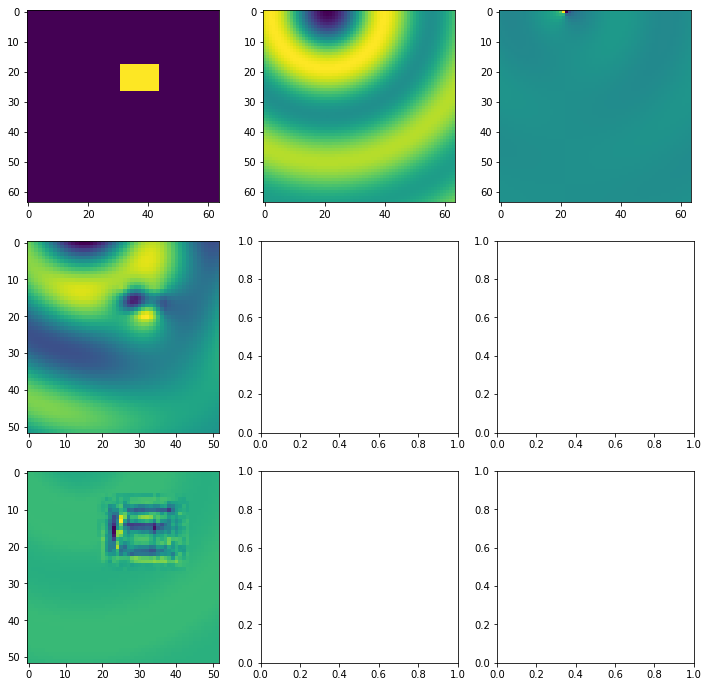

In [159]:
n = np.random.randint(0,2)
m = np.random.randint(0,batch_size)

# Ez, Hx, Hy mode
eps, Ez_vac, Hx_vac, Hy_vac = data_list[n][m]
# Ez_true, Hx_true, Hy_true = labels_list[n][m]
# Ez_pred, Hx_pred, Hy_pred = outputs_list[n][m]

# Just Ez mode
# eps, Ez_vac = data_list[n][m]
Ez_true = labels_list[n][m][0]
Ez_pred = outputs_list[n][m][0]

f, axarr = plt.subplots(3,3, figsize=(12,12))

axarr[0,0].imshow(eps)
axarr[0,1].imshow(Ez_vac)
axarr[0,2].imshow(Hx_vac)

axarr[1,0].imshow(Ez_true)
# axarr[1,1].imshow(Hx_true)
# axarr[1,2].imshow(Hy_true)

axarr[2,0].imshow(Ez_pred)
# axarr[2,1].imshow(Hx_pred)
# axarr[2,2].imshow(Hy_pred)
plt.show()

## Keras Model

In [3]:
# inputs = Input(shape=(64, 64, 1))#, 2))

# x = Conv2D(16, kernel_size=(11, 11), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(inputs)
# x = Conv2D(32, kernel_size=(11, 11), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=(1, 1), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# outputs = Reshape((32, 32))(x)

# model = Model(inputs=inputs, outputs=outputs)



# inputs = Input(shape=(64, 64, 2))

# x = Conv2D(16, kernel_size=11, data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(inputs)
# x = Conv2D(32, kernel_size=11, data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=5,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=5,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=3,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(128,kernel_size=3,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=1,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(1,  kernel_size=1,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# outputs = Reshape((32, 32))(x)

# model = Model(inputs=inputs, outputs=outputs)


# inputs = Input(shape=(64, 64, 1))
# x = Conv2D(1, kernel_size=11, data_format='channels_last', activation='relu', padding="same")(inputs)
# outputs = Reshape((64, 64))(x)


inputs = Input(shape=(64, 64, 1))

x = Conv2D(16, kernel_size=11, data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(inputs)
x = Conv2D(32, kernel_size=11, data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(64, kernel_size=5,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(64, kernel_size=5,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(64, kernel_size=3,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(128,kernel_size=3,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(64, kernel_size=1,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(1,  kernel_size=1,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
outputs = Reshape((32, 32))(x)

model = Model(inputs=inputs, outputs=outputs)

In [4]:
model.compile(loss=keras.losses.mean_squared_logarithmic_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 16)        1952      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        61984     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 36, 36, 64)        102464    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       73856     
__________

In [5]:
# x_data = np.stack((permittivities, proximities), axis=-1)
x_data = np.expand_dims(permittivities, axis=-1)
y_data = np.abs(Ez)[:,16:48, 16:48]
# y_data_shit = permittivities[:,16:48, 16:48]

In [7]:
history = model.fit(x_data, y_data,
                    epochs=1,
                    verbose=1,
                    validation_split = 0.1,
                    callbacks=[keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, batch_size=32, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq=32)])

Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 38s 42ms/step - loss: 2.2610 - acc: 0.5139 - val_loss: 1.1847 - val_acc: 0.5347


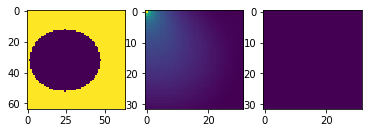

In [9]:
N = np.random.randint(0,1000)
x_pred = x_data[N:N+1]
y_real = y_data[N:N+1]

y_pred = model.predict(x_pred)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(x_pred[0,:,:,0])
# axarr[1].imshow(x_pred[0,16:48,16:48,0])
axarr[1].imshow(y_real[0])
axarr[2].imshow(y_pred[0])

In [13]:
np.max(y_real)

0.37050513960805986

In [14]:
# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()